<a href="https://colab.research.google.com/github/pedrobiqua/MineracaoDadosDados/blob/main/analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minera√ß√£o de dados

Nesse trabalho estamos retirando informa√ß√µes dos dados da base de dados **Census Income**.

Como metodologia, estamos aplicando o processo de **KDD (Knowledge Discovery in Databases)**, onde teremos as seguintes etapas:

- **Sele√ß√£o dos dados**:  
  Escolha dos atributos relevantes da base Census Income para o problema proposto.

- **Pr√©-processamento**:  
  Tratamento dos dados, incluindo:
  - Convers√£o de vari√°veis categ√≥ricas em formato num√©rico.
  - Normaliza√ß√£o de vari√°veis num√©ricas.

- **Transforma√ß√£o dos dados (Feature Engineering)**:  
  Cria√ß√£o de novas vari√°veis para enriquecer o conjunto de dados, como:
  - Cria√ß√£o de faixas et√°rias a partir da vari√°vel `age`.
  - Tempo Livre(`free_time`).
  - Propor√ß√£o de anos estudados(`education_age_ratio`).
  - C√°lculo de `capital_net` (`capital-gain` - `capital-loss`).
  - Simplifica√ß√£o do estado civil (`is_married`).

- **Minera√ß√£o de dados**:  
  Aplica√ß√£o de algoritmos de Machine Learning para identificar padr√µes e realizar a tarefa de classifica√ß√£o da renda (`<=50K` ou `>50K`).

- **Interpreta√ß√£o/Evalua√ß√£o dos resultados**:  
  An√°lise dos resultados obtidos pelos modelos, avaliando m√©tricas como:
  - acur√°cia.
  - precis√£o.
  - recall.
  - F1-score.

---

**Autores**: Pedro Bianchini de Quadros e Lucas Fernando Assun√ß√£o Cavalherie  
**Fonte**: [Census Income Dataset - UCI](https://archive.ics.uci.edu/dataset/20/census+income)

## Pend√™ncias

- Arrumar os dataframes, deixar tudo organizado;
- Testar com outros classificadores;
  - Pegar os que tem a melhor acur√°cia m√©dia
- Ver porque o Kmeans mudou o resultado, deve ser por conta de n√£o ter seed/ os df estarem ruins;
- Ver com o Lucas quais outros plots a gene pode fazer para melhorar no artigo

## Importando Bibliotecas Necessarias para analise dos dados

In [1]:
%pip install category_encoders
%pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np

## Importando Banco de Dados

In [3]:
adult = fetch_ucirepo(id=2)

In [4]:
# data (as pandas dataframes)
df = adult.data.features.copy()
df['income'] = adult.data.targets


print(df.shape)

(48842, 15)


In [5]:
# metadata
adult.metadata

{'uci_id': 2,
 'name': 'Adult',
 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult',
 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv',
 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ',
 'area': 'Social Science',
 'tasks': ['Classification'],
 'characteristics': ['Multivariate'],
 'num_instances': 48842,
 'num_features': 14,
 'feature_types': ['Categorical', 'Integer'],
 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'],
 'target_col': ['income'],
 'index_col': None,
 'has_missing_values': 'yes',
 'missing_values_symbol': 'NaN',
 'year_of_dataset_creation': 1996,
 'last_updated': 'Tue Sep 24 2024',
 'dataset_doi': '10.24432/C5XW20',
 'creators': ['Barry Becker', 'Ronny Kohavi'],
 'intro_paper': None,
 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was ex

In [6]:
# variable information
adult.variables

name     role         type      demographic  \
0              age  Feature      Integer              Age   
1        workclass  Feature  Categorical           Income   
2           fnlwgt  Feature      Integer             None   
3        education  Feature  Categorical  Education Level   
4    education-num  Feature      Integer  Education Level   
5   marital-status  Feature  Categorical            Other   
6       occupation  Feature  Categorical            Other   
7     relationship  Feature  Categorical            Other   
8             race  Feature  Categorical             Race   
9              sex  Feature       Binary              Sex   
10    capital-gain  Feature      Integer             None   
11    capital-loss  Feature      Integer             None   
12  hours-per-week  Feature      Integer             None   
13  native-country  Feature  Categorical            Other   
14          income   Target       Binary           Income   

                                          description units missing_values  
0                                                 N/A  None             no  
1   Private, Self-emp-not-inc, Self-emp-inc, Feder...  None            yes  
2                                                None  None             no  
3    Bachelors, Some-college, 11th, HS-grad, Prof-...  None             no  
4                                                None  None             no  
5   Married-civ-spouse, Divorced, Never-married, S...  None             no  
6   Tech-support, Craft-repair, Other-service, Sal...  None            yes  
7   Wife, Own-child, Husband, Not-in-family, Other...  None             no  
8   White, Asian-Pac-Islander, Amer-Indian-Eskimo,...  None             no  
9                                       Female, Male.  None             no  
10                                               None  None             no  
11                                               None  None             no  
12                                               None  None             no  
13  United-States, Cambodia, England, Puerto-Rico,...  None            yes  
14                                       >50K, <=50K.  None             no

## Pre-Processamento dos dados

In [7]:
def verificar_nulos(df):
    """
    Verifica se existem valores nulos em um DataFrame ou Series do pandas.

    Args:
        df (pd.DataFrame ou pd.Series): Objeto pandas a ser verificado.

    Returns:
        True se houver nulos, False caso contr√°rio.
    """
    if not isinstance(df, (pd.DataFrame, pd.Series)):
        raise TypeError("O objeto precisa ser um pandas DataFrame ou Series.")
    return df.isnull().values.any()

def percentual_nulos(df):
    """
    Mostra o percentual de valores nulos por coluna de um DataFrame.

    Args:
        df (pd.DataFrame): O DataFrame a ser analisado.

    Returns:
        pd.Series: S√©rie com o percentual de nulos por coluna.
    """
    return (df.isnull().mean() * 100).sort_values(ascending=False)

In [8]:
verificar_nulos(df)

np.True_

In [9]:
percentual_nulos(df)

occupation        1.977806
workclass         1.971664
native-country    0.560993
fnlwgt            0.000000
education         0.000000
education-num     0.000000
age               0.000000
marital-status    0.000000
relationship      0.000000
sex               0.000000
race              0.000000
capital-gain      0.000000
capital-loss      0.000000
hours-per-week    0.000000
income            0.000000
dtype: float64

In [10]:
# Remove linhas com valores nulos
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Remove o index
df = df.drop(columns=['fnlwgt'])

percentual_nulos(df)

age               0.0
workclass         0.0
education         0.0
education-num     0.0
marital-status    0.0
occupation        0.0
relationship      0.0
race              0.0
sex               0.0
capital-gain      0.0
capital-loss      0.0
hours-per-week    0.0
native-country    0.0
income            0.0
dtype: float64

## An√°lise das variaveis

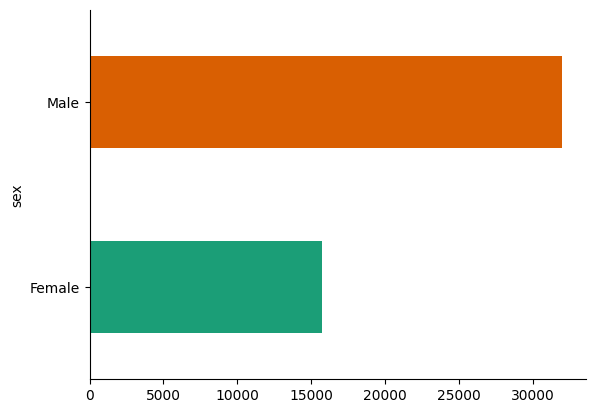

In [11]:
# @title sex

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('sex').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-12-8bc583eef501>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='age', y='marital-status', inner='box', palette='Dark2')


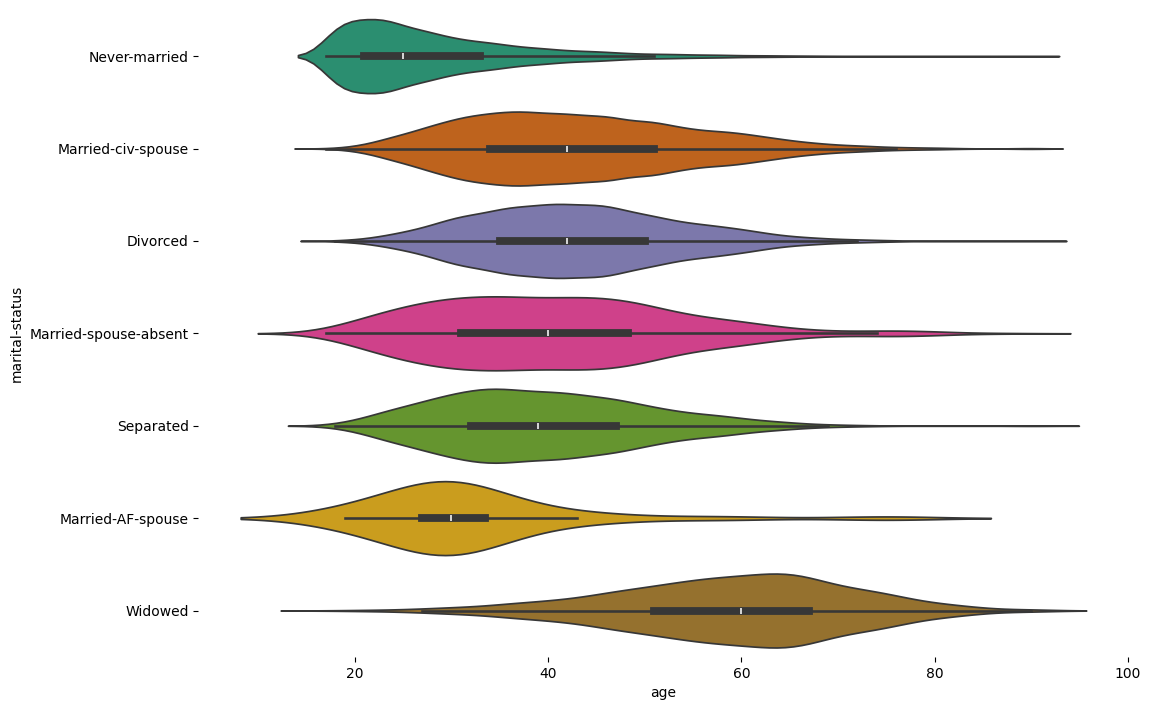

In [12]:
# @title marital-status vs age

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['marital-status'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='age', y='marital-status', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## Transforma√ß√£o dos dados

### Feature Engineering

Cria√ß√£o da faixa et√°ria

| Faixa | Idade |
|---------|-------|
| Jovem |(18‚Äì25)|
| Adulto |(26‚Äì45)|
| Meia-idade |(46‚Äì65)|
| Idoso|(66+)|

In [13]:
# df['age_group'] = pd.cut(df['age'], bins=[0,25,45,65,100], labels=['Young','Adult','Middle-Aged','Senior'])

"Capital l√≠quido"

In [14]:
# df['capital_net'] = df['capital-gain'] - df['capital-loss']

Propor√ß√£o de anos estudados por idade

In [15]:
# df['education_age_ratio'] = df['education-num'] / df['age']

Tempo livre

√â calculado usando as horas trabalhadas na semana, menos as 168 horas totais da semana

$$
24 \times 7 = 168 - horas \space trabalhadas

$$

In [16]:
# df['free_time'] = 168 - df['hours-per-week']

Casado ou n√£o

In [17]:
# df['is_married'] = df['marital-status'].apply(lambda x: 1 if x == 'Married-civ-spouse' else 0)

Obs: Posso combinar mais features, ver dedpois com o Lucas

### Encoding de Features

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from category_encoders import TargetEncoder

# Colunas categ√≥ricas por tipo de codifica√ß√£o
one_hot_cols = [
    "workclass",
    "marital-status",
    "relationship",
    "race",
    "sex",
    # "age_group"
]
ordinal_col = ["education"]
target_enc_cols = ["occupation", "native-country"]

# Colunas num√©ricas (incluindo as derivadas)
numeric_cols = [
    "age",
    # "fnlwgt",
    "education-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    # "capital_net",
    # "education_age_ratio",
    # "free_time",
    # "is_married"
]

# Ordem correta para encoding ordinal da escolaridade
education_order = [
    'Preschool', '1st-4th', '5th-6th', '7th-8th', '9th',
    '10th', '11th', '12th', 'HS-grad', 'Some-college',
    'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters',
    'Prof-school', 'Doctorate'
]

df_corr = df.copy()

# Encoders
one_hot_enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ordinal_enc = OrdinalEncoder(categories=[education_order])
target_enc = TargetEncoder()

# ColumnTransformer
encoder = ColumnTransformer(transformers=[
    ('onehot', one_hot_enc, one_hot_cols),
    ('ordinal', ordinal_enc, ordinal_col),
    ('target', target_enc, target_enc_cols),
    ('numeric', 'passthrough', numeric_cols)
])

In [19]:
X = df.drop(columns='income')
y = df['income']

X_encoded = encoder.fit_transform(X, y)
X_encoded

array([[   0.,    0.,    0., ..., 2174.,    0.,   40.],
       [   0.,    0.,    0., ...,    0.,    0.,   13.],
       [   0.,    0.,    0., ...,    0.,    0.,   40.],
       ...,
       [   0.,    0.,    0., ...,    0.,    0.,   50.],
       [   0.,    0.,    0., ..., 5455.,    0.,   40.],
       [   0.,    0.,    0., ...,    0.,    0.,   60.]])

In [20]:
# 1. Pegue os nomes das colunas do OneHotEncoder
onehot_feature_names = encoder.named_transformers_['onehot'].get_feature_names_out(one_hot_cols)

# 2. Junte os nomes de todas as colunas, na mesma ordem que foram passadas no ColumnTransformer
all_feature_names = list(onehot_feature_names) + ordinal_col + target_enc_cols + numeric_cols

# 3. Crie o DataFrame com os dados transformados e os nomes
df_final = pd.DataFrame(X_encoded, columns=all_feature_names)
df_final['income'] = y.values

In [21]:
df_corr

age         workclass  education  education-num      marital-status  \
0       39         State-gov  Bachelors             13       Never-married   
1       50  Self-emp-not-inc  Bachelors             13  Married-civ-spouse   
2       38           Private    HS-grad              9            Divorced   
3       53           Private       11th              7  Married-civ-spouse   
4       28           Private  Bachelors             13  Married-civ-spouse   
...    ...               ...        ...            ...                 ...   
47616   33           Private  Bachelors             13       Never-married   
47617   39           Private  Bachelors             13            Divorced   
47618   38           Private  Bachelors             13  Married-civ-spouse   
47619   44           Private  Bachelors             13            Divorced   
47620   35      Self-emp-inc  Bachelors             13  Married-civ-spouse   

              occupation   relationship                race     sex  \
0           Adm-clerical  Not-in-family               White    Male   
1        Exec-managerial        Husband               White    Male   
2      Handlers-cleaners  Not-in-family               White    Male   
3      Handlers-cleaners        Husband               Black    Male   
4         Prof-specialty           Wife               Black  Female   
...                  ...            ...                 ...     ...   
47616     Prof-specialty      Own-child               White    Male   
47617     Prof-specialty  Not-in-family               White  Female   
47618     Prof-specialty        Husband               White    Male   
47619       Adm-clerical      Own-child  Asian-Pac-Islander    Male   
47620    Exec-managerial        Husband               White    Male   

       capital-gain  capital-loss  hours-per-week native-country  income  
0              2174             0              40  United-States   <=50K  
1                 0             0              13  United-States   <=50K  
2                 0             0              40  United-States   <=50K  
3                 0             0              40  United-States   <=50K  
4                 0             0              40           Cuba   <=50K  
...             ...           ...             ...            ...     ...  
47616             0             0              40  United-States  <=50K.  
47617             0             0              36  United-States  <=50K.  
47618             0             0              50  United-States  <=50K.  
47619          5455             0              40  United-States  <=50K.  
47620             0             0              60  United-States   >50K.  

[47621 rows x 14 columns]

                     age  education-num  capital-gain  capital-loss  \
age             1.000000       0.033327      0.078006      0.057772   
education-num   0.033327       1.000000      0.125569      0.081799   
capital-gain    0.078006       0.125569      1.000000     -0.031691   
capital-loss    0.057772       0.081799     -0.031691      1.000000   
hours-per-week  0.079306       0.143727      0.082279      0.055360   

                hours-per-week  
age                   0.079306  
education-num         0.143727  
capital-gain          0.082279  
capital-loss          0.055360  
hours-per-week        1.000000  


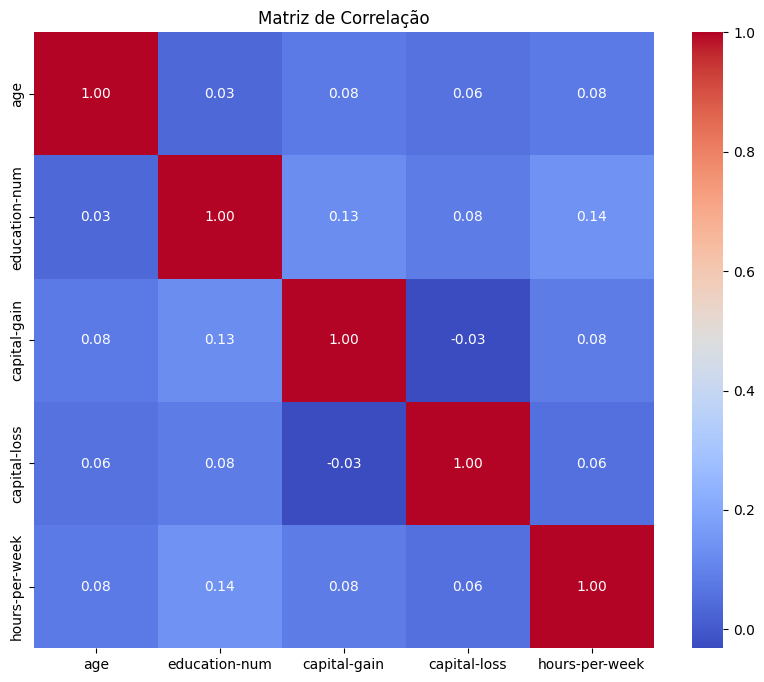

In [22]:
# @title Corela√ß√µes entre as variaveis

import seaborn as sns
import matplotlib.pyplot as plt

# Exclui colunas apenas para ver as correla√ß√µes
df_corr = df_corr.drop(columns=['income'])
cols_to_drop = one_hot_cols + ordinal_col + target_enc_cols
df_corr = df_corr.drop(columns=cols_to_drop)

correlacoes = df_corr.corr()

# Exibe a matriz
print(correlacoes)

plt.figure(figsize=(10, 8))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correla√ß√£o")
plt.show()



### Algoritmos de Scaling

In [23]:
# TODO: Ver com o Lucas, se √© necess√°rio

### Resultados Transforma√ß√µes

In [24]:
df_final

workclass_?  workclass_Federal-gov  workclass_Local-gov  \
0              0.0                    0.0                  0.0   
1              0.0                    0.0                  0.0   
2              0.0                    0.0                  0.0   
3              0.0                    0.0                  0.0   
4              0.0                    0.0                  0.0   
...            ...                    ...                  ...   
47616          0.0                    0.0                  0.0   
47617          0.0                    0.0                  0.0   
47618          0.0                    0.0                  0.0   
47619          0.0                    0.0                  0.0   
47620          0.0                    0.0                  0.0   

       workclass_Never-worked  workclass_Private  workclass_Self-emp-inc  \
0                         0.0                0.0                     0.0   
1                         0.0                0.0                     0.0   
2                         0.0                1.0                     0.0   
3                         0.0                1.0                     0.0   
4                         0.0                1.0                     0.0   
...                       ...                ...                     ...   
47616                     0.0                1.0                     0.0   
47617                     0.0                1.0                     0.0   
47618                     0.0                1.0                     0.0   
47619                     0.0                1.0                     0.0   
47620                     0.0                0.0                     1.0   

       workclass_Self-emp-not-inc  workclass_State-gov  workclass_Without-pay  \
0                             0.0                  1.0                    0.0   
1                             1.0                  0.0                    0.0   
2                             0.0                  0.0                    0.0   
3                             0.0                  0.0                    0.0   
4                             0.0                  0.0                    0.0   
...                           ...                  ...                    ...   
47616                         0.0                  0.0                    0.0   
47617                         0.0                  0.0                    0.0   
47618                         0.0                  0.0                    0.0   
47619                         0.0                  0.0                    0.0   
47620                         0.0                  0.0                    0.0   

       marital-status_Divorced  ...  sex_Male  education  occupation  \
0                          0.0  ...       1.0       12.0    0.599213   
1                          0.0  ...       1.0       12.0    1.285573   
2                          1.0  ...       1.0        8.0    0.470474   
3                          0.0  ...       1.0        6.0    0.470474   
4                          0.0  ...       0.0       12.0    1.223241   
...                        ...  ...       ...        ...         ...   
47616                      0.0  ...       1.0       12.0    1.223241   
47617                      1.0  ...       0.0       12.0    1.223241   
47618                      0.0  ...       1.0       12.0    1.223241   
47619                      1.0  ...       1.0       12.0    0.599213   
47620                      0.0  ...       1.0       12.0    1.285573   

       native-country   age  education-num  capital-gain  capital-loss  \
0            0.815587  39.0           13.0        2174.0           0.0   
1            0.815587  50.0           13.0           0.0           0.0   
2            0.815587  38.0            9.0           0.0           0.0   
3            0.815587  53.0            7.0           0.0           0.0   
4            0.801471  28.0           13.0           0.0           0.0   
...               .

## Machine Learning

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, mean_squared_error, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Separando X e y
X = df_final.drop(columns=['income'])
y = df_final['income']

# Separar para classifica√ß√£o e regress√£o
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Classifica√ß√£o

In [27]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

print("üî∑ Random Forest - Classifica√ß√£o")
print(classification_report(y_test, y_pred))


üî∑ Random Forest - Classifica√ß√£o
              precision    recall  f1-score   support

       <=50K       0.61      0.76      0.68      4924
      <=50K.       0.28      0.17      0.21      2246
        >50K       0.49      0.48      0.49      1617
       >50K.       0.22      0.13      0.17       738

    accuracy                           0.53      9525
   macro avg       0.40      0.39      0.39      9525
weighted avg       0.48      0.53      0.50      9525



### Regress√£o

In [28]:
# from sklearn.linear_model import LinearRegression

# # Converter alvo para bin√°rio
# y_num = y.map({'<=50K': 0, '>50K': 1})
# X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_num, test_size=0.2, random_state=42)

# X_train_r_scaled = scaler.fit_transform(X_train_r)
# X_test_r_scaled = scaler.transform(X_test_r)

# reg = LinearRegression()
# reg.fit(X_train_r_scaled, y_train_r)
# y_pred_r = reg.predict(X_test_r_scaled)

# print("üî∂ Linear Regression - Regress√£o")
# print("MSE:", mean_squared_error(y_test_r, y_pred_r))


### Clusteriza√ß√£o

üü£ KMeans - Clusteriza√ß√£o
Silhouette Score: 0.9862778797458366


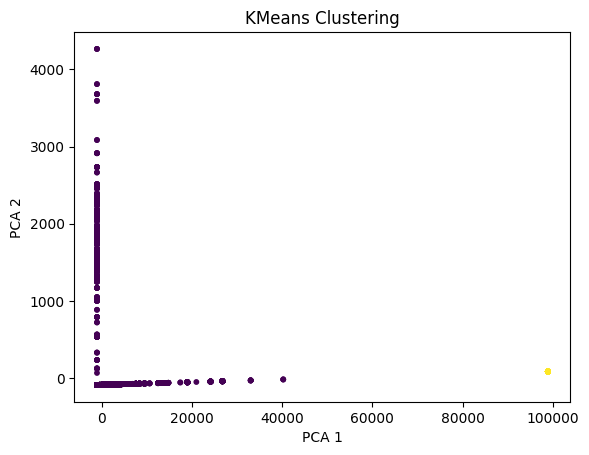

In [29]:
from sklearn.cluster import KMeans

# PCA para visualiza√ß√£o
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X)

# Avalia√ß√£o
score = silhouette_score(X, labels)
print("üü£ KMeans - Clusteriza√ß√£o")
print("Silhouette Score:", score)

# Visualiza√ß√£o
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=10)
plt.title("KMeans Clustering")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


### Compilado dos Algoritmos

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, mean_squared_error, silhouette_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

def rodar_pipeline_modelos(df_final):
    resultados = []

    # Separar vari√°veis
    X = df_final.drop(columns=['income'])
    y_class = df_final['income']
    # y_reg = y_class.map({'<=50K': 0, '>50K': 1})

    # Dividir em treino/teste
    X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)
    # _, _, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

    # Escalar os dados
    scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train)
    # X_test_scaled = scaler.transform(X_test)
    # X_scaled = scaler.fit_transform(X)

    ### CLASSIFICA√á√ÉO ###
    param_grid = {
        'n_estimators': [50, 100, 200],            # n√∫mero de √°rvores
        'max_depth': [None, 10, 20],               # profundidade m√°xima
        'min_samples_split': [2, 5, 10],           # m√≠nimo de amostras para dividir
        'max_features': ['sqrt', 'log2']           # n√∫mero de features consideradas no split
    }


    # Configurando o GridSearchCV
    grid_search = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        scoring='accuracy',
        cv=3,
        n_jobs=-1
    )

    # Executando o GridSearch nos dados de treino
    grid_search.fit(X_train, y_train)

    # Usando o melhor modelo encontrado para prever
    best_clf = grid_search.best_estimator_
    y_pred_class = best_clf.predict(X_test)

    # Gerando o relat√≥rio de classifica√ß√£o
    report = classification_report(y_test, y_pred_class, output_dict=True)

    # Salvando os resultados
    resultados.append({
        'Tipo': 'Classifica√ß√£o',
        'Algoritmo': 'Random Forest',
        'M√©trica': 'Acur√°cia',
        'Valor': report['accuracy'],
        'Melhores Par√¢metros': grid_search.best_params_
    })
    # resultados.append({
    #     'Tipo': 'Classifica√ß√£o',
    #     'Algoritmo': 'Random Forest',
    #     'M√©trica': 'F1 (>50K)',
    #     'Valor': report['>50K']['f1-score'],
    #     'Melhores Par√¢metros': grid_search.best_params_
    # })

    ### CLUSTERIZA√á√ÉO ###
    # kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
    # labels = kmeans.fit_predict(X_scaled)
    # silhouette = silhouette_score(X_scaled, labels)
    # resultados.append({
    #     'Tipo': 'Clusteriza√ß√£o',
    #     'Algoritmo': 'KMeans',
    #     'M√©trica': 'Silhouette Score',
    #     'Valor': silhouette
    # })

    # Converter para DataFrame
    return pd.DataFrame(resultados)


In [31]:
resultados_df = rodar_pipeline_modelos(df_final)
print(resultados_df)

            Tipo      Algoritmo   M√©trica     Valor  \
0  Classifica√ß√£o  Random Forest  Acur√°cia  0.588136   

                                 Melhores Par√¢metros  
0  {'max_depth': 10, 'max_features': 'sqrt', 'min...  


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
